In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import random



import json



from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import joblib

/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_FOLDER = './evaluations'
N_OPTIONS = 3
TRAFFIC = "custom-2way-single-intersection3"
# MODEL = f"option_critic_nn_100000_steps_curriculum_3_options_custom-2way-single-intersection3_100000_steps"
MODEL = "cyclic_15"
PREFIX = f"{MODEL}_{TRAFFIC}"  
DEPTH=5

In [3]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs

def load_data(prefix):
    df_single_episode = pd.read_csv(f'{BASE_FOLDER}/{prefix}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    
    df_multiple_episodes = None
    # df_multiple_episodes = pd.read_csv(f'{BASE_FOLDER}/{prefix}_100_episode.csv')
    # df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    return df_single_episode, df_multiple_episodes

def get_obs(df, index):
    current_option = df.option.to_list()[index]
    total_observation = []
    unnested_obs = {}
    for tf_id, observation_dict in json.loads(df.obs.to_list()[index]).items():
    #   current_time = observation_dict["current_time"]
        phase_ids = observation_dict["phase_ids"]
        min_green = observation_dict["min_green"]
        density = observation_dict["density"]
        queue = observation_dict["queue"]
        delta_queue = observation_dict["delta_queue"]
        observation = phase_ids + min_green + density + queue + delta_queue
        total_observation.extend(observation)
        for key, value in observation_dict.items():
            if isinstance(value, list):
                for index, item in enumerate(value):
                    unnested_obs[f"{tf_id}_{key}_{index}"] = item
            else:
                unnested_obs[f"{tf_id}_{key}"] = value
    total_observation = np.array(total_observation, dtype=np.float32)
    encoded_option = np.zeros(N_OPTIONS)
    encoded_option[current_option] = 1
    total_observation = np.append(total_observation, encoded_option)
    
    for o in range(N_OPTIONS):
        key = f"option_{o}"
        if o == current_option:
            value = 1
        else:
            value = 0
        unnested_obs[f"{tf_id}_{key}"] = value

    return total_observation, current_option, unnested_obs

def get_random_obs(df):
    index = random.randrange(df.shape[0])
    return get_obs(df, index)

def prep_state(obs):
    """Convert the provided observation to a tensor

    Args:
        obs (Any): Obs provided by the environment
    """

    # Unnest observation
    obs_array = []
    if isinstance(obs, dict):
        for _, obs_arr in obs.items():
            obs_array.extend(obs_arr)
    else:
        obs_array.extend(obs)


    # include option information
    # Simplified to make it easier to manage
    # encoded_option = np.zeros(self.num_options)
    # encoded_option[self.current_option] = 1
    # obs = np.append(obs, encoded_option)

    # Convert to tensor
    obs_tensor = to_tensor(obs_array)
    if obs_tensor.ndim < 4:
        obs_tensor = obs_tensor.unsqueeze(0)
    obs_tensor = obs_tensor.to("cpu")
    return obs_tensor


OPTIONS_DICT = {
    "0-1000": 0,
    "1000-2000": 1,
    "2000-3000": 0,
    "3000-4000": 1,
    "4000-5000": 0,
}

def get_option(options_dict: dict, current_step: int):
    current_step = int(current_step)
    for steps, option in options_dict.items():
        start, end = steps.split("-")
        if int(start) <= current_step < int(end):
            return option
    return 0

In [4]:
df_single_episode, _ = load_data(PREFIX)

<Axes: xlabel='step'>

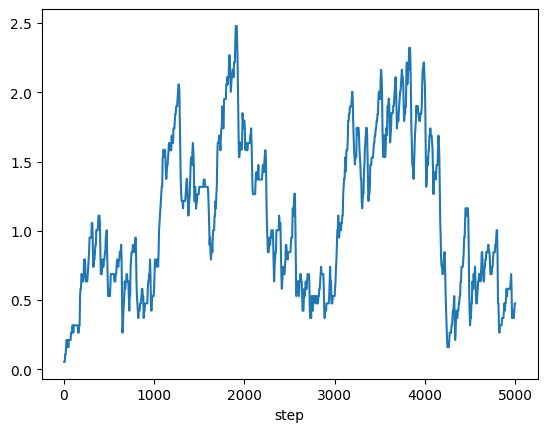

In [5]:
df_single_episode.lane_density.plot()

In [55]:
df_single_episode.obs.to_list()[0]

'{"t": {"phase_ids": [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "min_green": [0], "density": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "queue": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "delta_queue": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "waiting_times": [[], [], [], [], [], [], [], []], "average_speed": 1.0}}'

In [21]:
# All features
extracted_features = []
for index in range(1000):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    feature_dict = {}
    for key, value in unnested_dict.items():
        if isinstance(value, list):
            for i, _v in enumerate(value):
                feature_dict[f"{key}_{i}"] = _v
        else:
            feature_dict[key] = value
    feature_dict["option"] = get_option(OPTIONS_DICT, index*5)
    extracted_features.append(feature_dict)
df_features = pd.DataFrame(extracted_features)

X = df_features.loc[:, df_features.columns != 'option'] # Select all columns except the option column
y = df_features.loc[:, df_features.columns == 'option']   # Select only the option column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = RandomForestClassifier(max_depth=DEPTH, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test Accuracy: 0.97


In [42]:
# Removed:
# Density
extracted_features = []
for index in range(1000):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    feature_dict = {}
    for key, value in unnested_dict.items():
        if isinstance(value, list):
            for i, _v in enumerate(value):
                feature_dict[f"{key}_{i}"] = _v
        elif "density" in key:
            continue
        else:
            feature_dict[key] = value
    feature_dict["option"] = get_option(OPTIONS_DICT, index*5)
    extracted_features.append(feature_dict)
df_features = pd.DataFrame(extracted_features)

X = df_features.loc[:, df_features.columns != 'option'] # Select all columns except the option column
y = df_features.loc[:, df_features.columns == 'option']   # Select only the option column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = RandomForestClassifier(max_depth=DEPTH, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test Accuracy: 0.96


In [41]:
# Removed:
# Density
# Phaseid history
extracted_features = []
for index in range(1000):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    feature_dict = {}
    for key, value in unnested_dict.items():
        if isinstance(value, list):
            for i, _v in enumerate(value):
                feature_dict[f"{key}_{i}"] = _v
        elif "density" in key:
            continue
        elif "phase_ids" in key:
            if key in ["t_phase_ids_0", "t_phase_ids_4", "t_phase_ids_8", "t_phase_ids_12", "t_phase_ids_16"]:
                feature_dict[key] = value
        else:
            feature_dict[key] = value
    feature_dict["option"] = get_option(OPTIONS_DICT, index*5)
    extracted_features.append(feature_dict)
df_features = pd.DataFrame(extracted_features)

X = df_features.loc[:, df_features.columns != 'option'] # Select all columns except the option column
y = df_features.loc[:, df_features.columns == 'option']   # Select only the option column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = RandomForestClassifier(max_depth=DEPTH, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test Accuracy: 0.97


In [47]:
# Removed:
# Density
# Phaseid history
extracted_features = []
for index in range(1000):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    feature_dict = {}
    for key, value in unnested_dict.items():
        if isinstance(value, list):
            for i, _v in enumerate(value):
                feature_dict[f"{key}_{i}"] = _v
        elif "density" in key:
            continue
        elif "phase_ids" in key:
            if key in ["t_phase_ids_0", "t_phase_ids_4", "t_phase_ids_8", "t_phase_ids_12", "t_phase_ids_16"]:
                feature_dict[key] = value
        else:
            feature_dict[key] = value
    feature_dict["option"] = get_option(OPTIONS_DICT, index*5)
    extracted_features.append(feature_dict)
df_features = pd.DataFrame(extracted_features)

X = df_features.loc[:, df_features.columns != 'option'] # Select all columns except the option column
y = df_features.loc[:, df_features.columns == 'option']   # Select only the option column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = RandomForestClassifier(max_depth=DEPTH, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test Accuracy: 0.97


In [46]:
# Removed:
# Density
# Phaseid history
# Used last waiting time
extracted_features = []
for index in range(1000):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    feature_dict = {}
    for key, value in unnested_dict.items():
        if "waiting_times" in key:
            if not value:
                feature_dict[key] = 0
            else:
                feature_dict[key] = value[-1]
        elif "phase_ids" in key:
            if key in ["t_phase_ids_0", "t_phase_ids_4", "t_phase_ids_8", "t_phase_ids_12", "t_phase_ids_16"]:
                feature_dict[key] = value
        elif "density" in key:
            continue
        else:
            feature_dict[key] = value
    feature_dict["option"] = get_option(OPTIONS_DICT, index*5)
    extracted_features.append(feature_dict)
df_features = pd.DataFrame(extracted_features)

X = df_features.loc[:, df_features.columns != 'option'] # Select all columns except the option column
y = df_features.loc[:, df_features.columns == 'option']   # Select only the option column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = RandomForestClassifier(max_depth=DEPTH, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test Accuracy: 0.89


In [5]:
# Removed:
# Density
# Phaseid history
# Used average waiting time
extracted_features = []
for index in range(1000):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    feature_dict = {}
    for key, value in unnested_dict.items():
        if "waiting_times" in key:
            continue
            # if not value:
            #    feature_dict[key] = 0
            #else:
            #    feature_dict[key] = np.mean(value)
        elif "option" in key:
            continue
        elif "min_green" in key:
            continue
        elif "density" in key:
            continue
        else:
            feature_dict[key] = value
    feature_dict["option"] = get_option(OPTIONS_DICT, index*5)
    extracted_features.append(feature_dict)
df_features = pd.DataFrame(extracted_features)

X = df_features.loc[:, df_features.columns != 'option'] # Select all columns except the option column
y = df_features.loc[:, df_features.columns == 'option']   # Select only the option column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = RandomForestClassifier(max_depth=DEPTH, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test Accuracy: 0.91


In [6]:
joblib.dump(clf, "./models/option_classifier.joblib")

['./models/option_classifier.joblib']

In [35]:
# Removed:
# Density
# Phaseid history
# Used max waiting time
extracted_features = []
for index in range(1000):
    obs, current_option, unnested_dict = get_obs(df_single_episode, index)
    feature_dict = {}
    for key, value in unnested_dict.items():
        if "waiting_times" in key:
            if not value:
                feature_dict[key] = 0
            else:
                feature_dict[key] = max(value)
        elif "phase_ids" in key:
            if key in ["t_phase_ids_0", "t_phase_ids_4", "t_phase_ids_8", "t_phase_ids_12", "t_phase_ids_16"]:
                feature_dict[key] = value
        elif "density" not in key:
            feature_dict[key] = value
    feature_dict["option"] = get_option(OPTIONS_DICT, index*5)
    extracted_features.append(feature_dict)
df_features = pd.DataFrame(extracted_features)

X = df_features.loc[:, df_features.columns != 'option'] # Select all columns except the option column
y = df_features.loc[:, df_features.columns == 'option']   # Select only the option column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


clf = RandomForestClassifier(max_depth=DEPTH, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.89


/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [57]:
X.columns

TypeError: 'Index' object is not callable

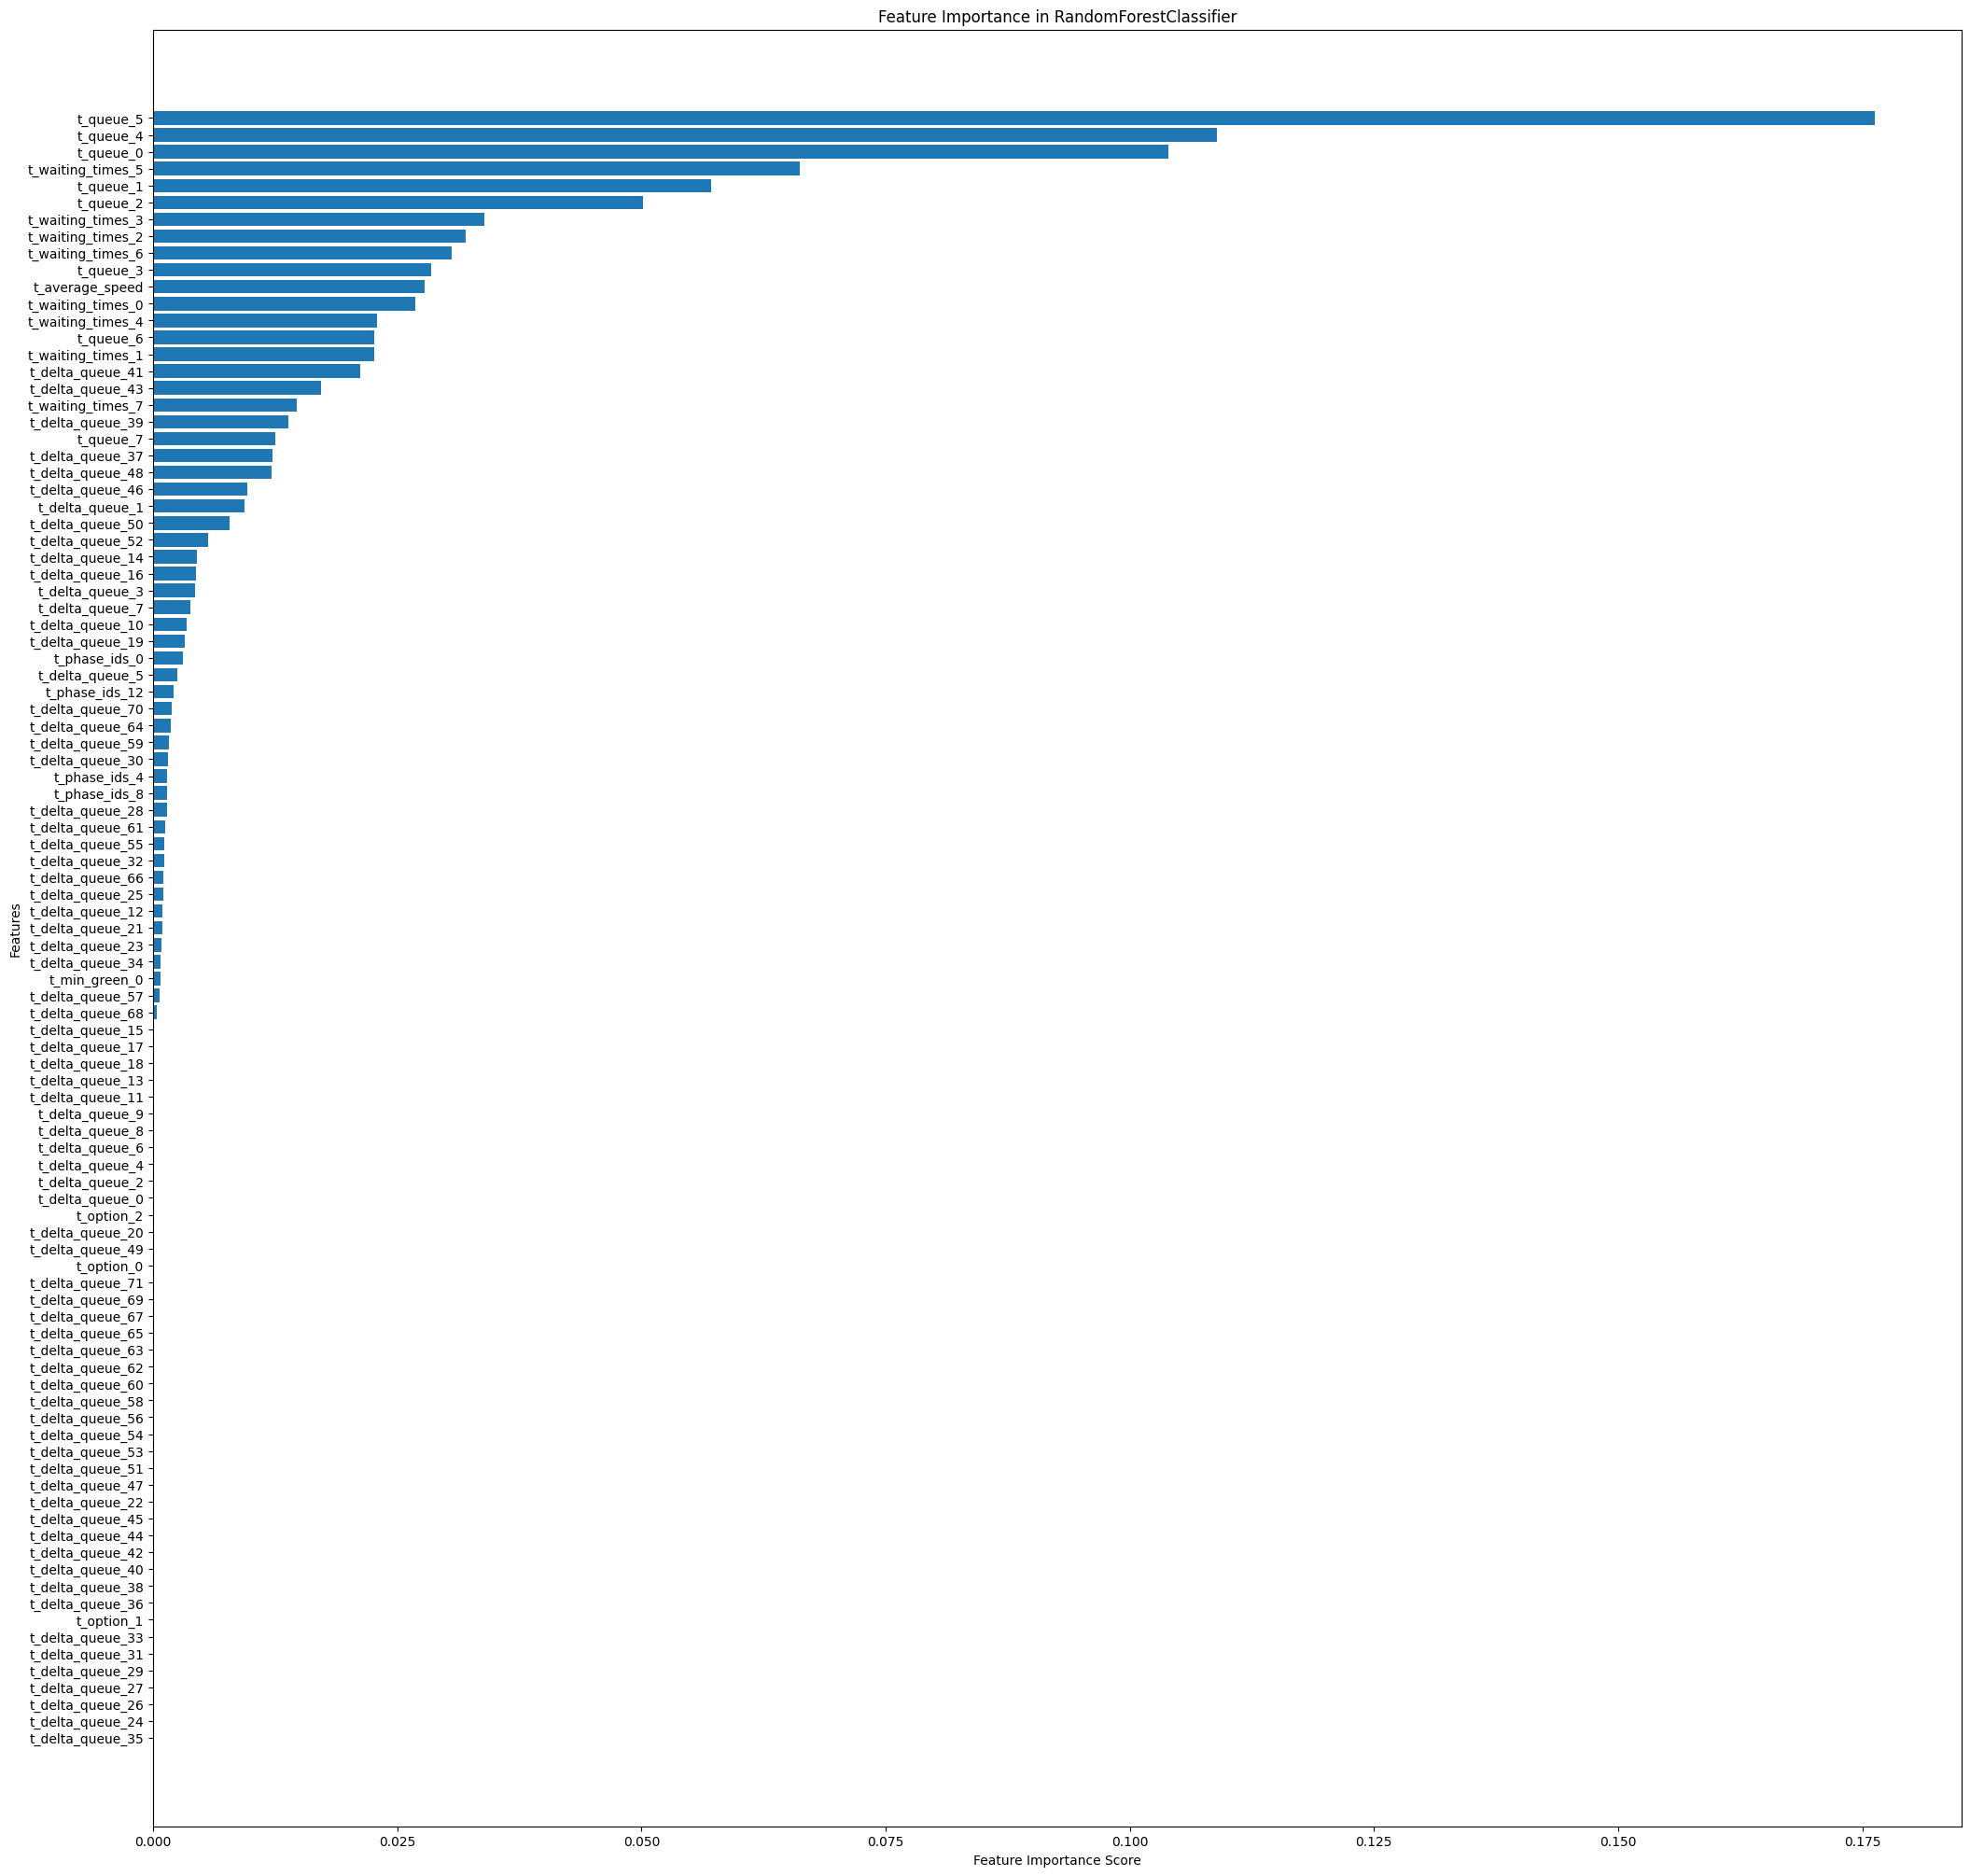

In [59]:

# Get feature importance scores
feature_importance = clf.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importance for better visualization
sorted_idx = np.argsort(feature_importance)

# Plot feature importance
plt.figure(figsize=(25, 25))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in RandomForestClassifier")
plt.show()

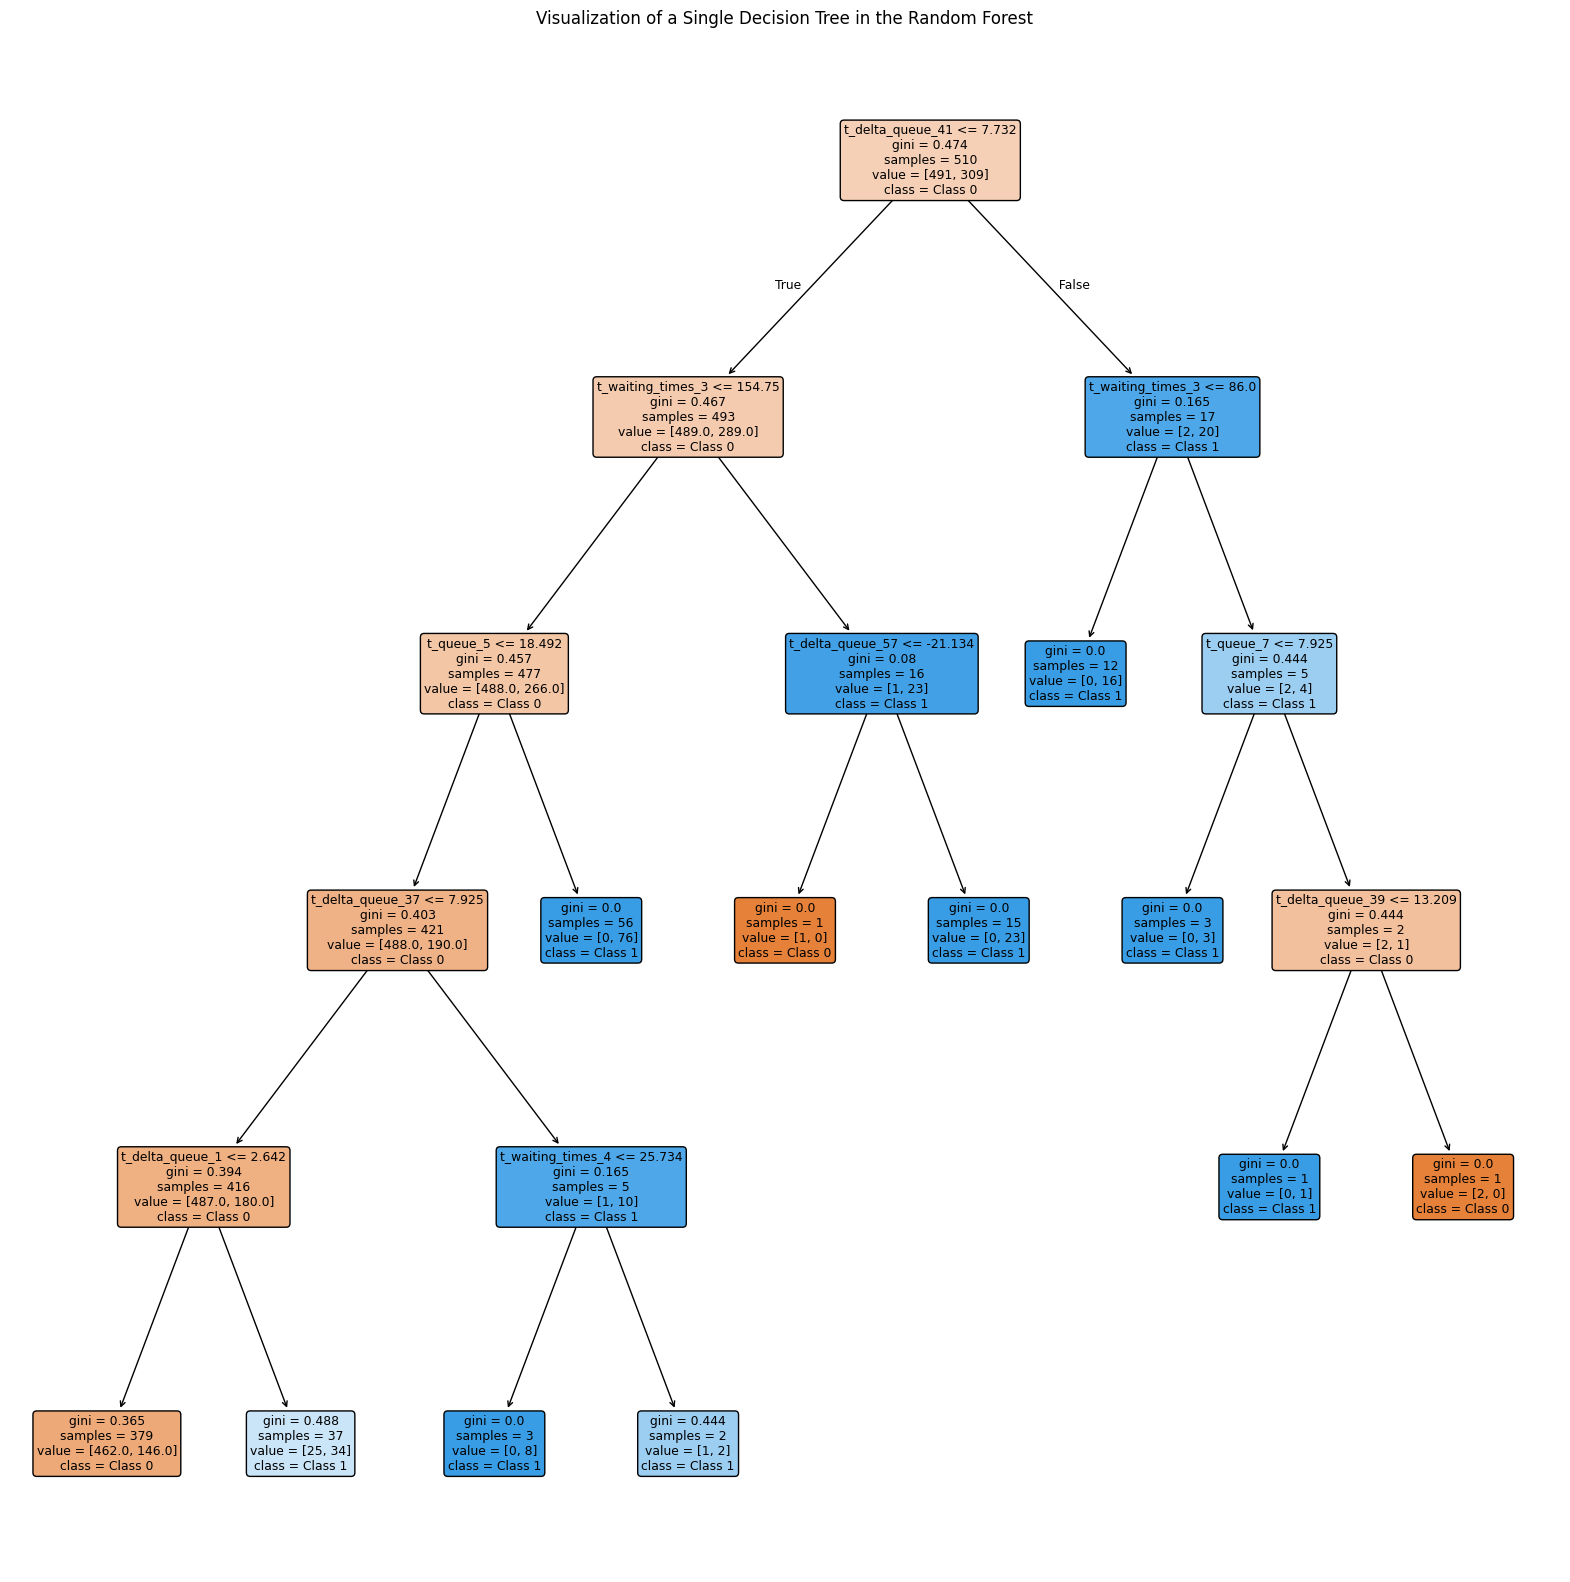

In [60]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Select one tree from the forest
single_tree = clf.estimators_[0]  # The first decision tree

# Plot the decision tree
plt.figure(figsize=(20, 20))
plot_tree(single_tree, feature_names=X.columns, filled=True, rounded=True, class_names=["Class 0", "Class 1"])
plt.title("Visualization of a Single Decision Tree in the Random Forest")
plt.show()